# Observe other vision practices that have moved to large messaging in Spine

On the 23rd March 2021, three more Vision practices enabled large messaging for GP2GP. We want to look at our Spine data for these practices to identify how their failure rates have changed since moving to large messaging. 

### Scope

Analyse spine data for the following three practices, for transfers both in and out:

Went live with large messaging from: 23.03.21 - 12.16pm 

User ID | Practice Code | Practice Name

#668 | M89019 | Hobs Moat Medical Centre

#33018 | M82010 | Drayton Medical Centre

#857 | H84023 | Essex House Surgery

- Document the technical success rate of their transfers for three months prior to 23.03
- Document a high level breakdown of reasons for failures for this time period.
- Document the technical success rate of their transfers since 23.03. 
- Document a high level breakdown of reasons for this time period

 
### Acceptance Criteria
- We are able to compare the technical success rate for these two practices before and after enabling attachments, and communicate to stakeholders how much their failure rates have changed. 
- We are able to tell the Vision team the reasons for some transfers still failing since moving to Large messaging

In [6]:
from datetime import datetime,timedelta
import matplotlib.pyplot as plt

practice_codes=["M89019","M82010","H84023"]
time_of_switch=datetime(year=2021, month=3, day=23, hour=12, minute=16)
window=timedelta(28) # Number of Days before and after switch to consider changes

start_time=time_of_switch-window
end_time=time_of_switch+window

In [7]:
end_time

datetime.datetime(2021, 4, 20, 12, 16)

In [8]:
import pandas as pd
import numpy as np

transfer_file_location = "s3://prm-gp2gp-data-sandbox-dev/transfers-duplicates-hypothesis/"
transfer_files = [
    "9-2020-transfers.parquet",
    "10-2020-transfers.parquet",
    "11-2020-transfers.parquet",
    "12-2020-transfers.parquet",
    "1-2021-transfers.parquet",
    "2-2021-transfers.parquet",
    "3-2021-transfers.parquet",
    "4-2021-transfers.parquet",
]
transfer_input_files = [transfer_file_location + f for f in transfer_files]
transfers_raw = pd.concat((
    pd.read_parquet(f)
    for f in transfer_input_files
))
# This is only needed when using transfers-duplicates-hypothesis datasets
transfers_raw = transfers_raw.drop(["sending_supplier", "requesting_supplier"], axis=1)

# Given the findings in PRMT-1742 - many duplicate EHR errors are misclassified, the below reclassifies the relevant data
successful_transfers_bool = transfers_raw['request_completed_ack_codes'].apply(lambda x: True in [(np.isnan(i) or i==15) for i in x])
transfers = transfers_raw.copy()
transfers.loc[successful_transfers_bool, "status"] = "INTEGRATED"

# Pending (Sender Error) Code
pending_sender_error_codes=[6,7,10,24,30,23,14,99]
transfers_with_pending_sender_code_bool=transfers['sender_error_code'].isin(pending_sender_error_codes)
transfers_with_pending_with_error_bool=transfers['status']=='PENDING_WITH_ERROR'
transfers_which_need_pending_to_failure_change_bool=transfers_with_pending_sender_code_bool & transfers_with_pending_with_error_bool
transfers.loc[transfers_which_need_pending_to_failure_change_bool,'status']='FAILED'

# Add integrated Late status
eight_days_in_seconds=8*24*60*60
transfers_after_sla_bool=transfers['sla_duration']>eight_days_in_seconds
transfers_with_integrated_bool=transfers['status']=='INTEGRATED'
transfers_integrated_late_bool=transfers_after_sla_bool & transfers_with_integrated_bool
transfers.loc[transfers_integrated_late_bool,'status']='INTEGRATED LATE'


# Supplier name mapping
supplier_renaming = {
    "EGTON MEDICAL INFORMATION SYSTEMS LTD (EMIS)":"EMIS",
    "IN PRACTICE SYSTEMS LTD":"Vision",
    "MICROTEST LTD":"Microtest",
    "THE PHOENIX PARTNERSHIP":"TPP",
    None: "Unknown"
}

asid_lookup_file = "s3://prm-gp2gp-data-sandbox-dev/asid-lookup/asidLookup-Mar-2021.csv.gz"
asid_lookup = pd.read_csv(asid_lookup_file)
lookup = asid_lookup[["ASID", "MName", "NACS","OrgName"]]

transfers = transfers.merge(lookup, left_on='requesting_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'MName': 'requesting_supplier', 'ASID': 'requesting_supplier_asid', 'NACS': 'requesting_ods_code',"OrgName":'requesting_practice'}, axis=1)
transfers = transfers.merge(lookup, left_on='sending_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'MName': 'sending_supplier', 'ASID': 'sending_supplier_asid', 'NACS': 'sending_ods_code',"OrgName":'sending_practice'}, axis=1)

transfers["sending_supplier"] = transfers["sending_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())
transfers["requesting_supplier"] = transfers["requesting_supplier"].replace(supplier_renaming.keys(), supplier_renaming.values())

# list(row['sender_error_code'], , row['request_completed_ack_codes'])
transfers['all_errors']=transfers.apply(lambda row:np.concatenate((np.append(row["intermediate_error_codes"], row["sender_error_code"]),row['request_completed_ack_codes'])), axis=1)
transfers['all_errors']=transfers['all_errors'].apply(lambda error_list:[error for error in error_list if np.isfinite(error)])



transfers['unique_errors']=transfers['all_errors'].apply(set).apply(list)



In [9]:
error_code_lookup_file = pd.read_csv("https://raw.githubusercontent.com/nhsconnect/prm-gp2gp-data-sandbox/master/data/gp2gp_response_codes.csv")

### Extract the data relevant to the practices in question

In [10]:
requesting_transfers_bool=transfers["requesting_ods_code"].isin(practice_codes)
requesting_transfers=transfers.loc[requesting_transfers_bool].copy()
requesting_transfers['ods_code']=requesting_transfers['requesting_ods_code']
requesting_transfers['transfer type']='Requesting'
requesting_transfers['practice']=requesting_transfers['requesting_practice']

sending_transfers_bool=transfers["sending_ods_code"].isin(practice_codes)
sending_transfers=transfers.loc[sending_transfers_bool].copy()
sending_transfers['ods_code']=sending_transfers['sending_ods_code']
sending_transfers['transfer type']='Sending'
sending_transfers['practice']=sending_transfers['sending_practice']

relevant_transfers=pd.concat([requesting_transfers,sending_transfers],axis=0)

In [11]:
relevant_transfers['all_errors']=relevant_transfers.apply(lambda row:np.concatenate((np.append(row["intermediate_error_codes"], row["sender_error_code"]),row['request_completed_ack_codes'])), axis=1)
relevant_transfers['all_errors']=relevant_transfers['all_errors'].apply(lambda error_list:[error for error in error_list if np.isfinite(error)])
relevant_transfers['unique_errors']=relevant_transfers['all_errors'].apply(set).apply(list)

In [12]:
relevant_transfers['Large Messaging Available']=relevant_transfers['date_requested']>time_of_switch
relevant_transfers_in_time_window_bool=(relevant_transfers['date_requested']>=start_time) & (relevant_transfers['date_requested']<=end_time)
relevant_transfers=relevant_transfers.loc[relevant_transfers_in_time_window_bool]
relevant_transfers['Large Messaging Available']=relevant_transfers['Large Messaging Available'].astype(str)

In [35]:
lm_error_codes=[14,23,29,30,31]
relevant_transfers['Contains LM related error']=relevant_transfers['all_errors'].apply(lambda error_list: len(set(error_list).intersection(set(lm_error_codes)))>0)
error_code_lookup_file.set_index('ErrorCode').loc[lm_error_codes]

,ErrorName,ResponseText
ErrorCode,,
14,Req not LM compliant,Message not sent because requesting practice i...
23,Sender not LM compliant,Message not sent because sending practice is n...
29,LM reassembly,Large Message Re-assembly failure
30,LM general failure,Large Message general failure
31,Missing LM,The overall EHR Extract has been rejected beca...


## What is the change in outcomes (status) as a result?

In [14]:
def outcomes_pc_table(transfers_df,pivot_index,percentage=True):
    outcomes_table=pd.pivot_table(transfers_df,index=pivot_index,columns='status',values='conversation_id',aggfunc='count').fillna(0).astype(int)
    if percentage:
        outcomes_table=(100*outcomes_table.div(outcomes_table.sum(axis=1),axis=0)).round(2)
        outcomes_table.columns=outcomes_table.columns + ' %'
    return outcomes_table

In [15]:
high_level_table=outcomes_pc_table(relevant_transfers,['Large Messaging Available'])
#high_level_table.T.plot.pie(subplots=True,figsize=(15,10),legend=False,autopct='%1.1f%%')
#plt.tight_layout()
high_level_table

status,FAILED %,INTEGRATED %,INTEGRATED LATE %,PENDING %,PENDING_WITH_ERROR %
Large Messaging Available,,,,,
False,43.78,46.89,1.04,7.88,0.41
True,2.66,82.45,0.53,13.83,0.53


In [16]:
mid_level_table=outcomes_pc_table(relevant_transfers,['transfer type','Large Messaging Available'])
#mid_level_table.T.plot.pie(subplots=True,layout=(2,2),figsize=(15,15),legend=False,autopct='%1.1f%%')
#plt.tight_layout()
mid_level_table

status                                   FAILED %  INTEGRATED %  \
transfer type Large Messaging Available                           
Requesting    False                         52.67         39.15   
              True                           4.21         82.63   
Sending       False                         31.34         57.71   
              True                           1.08         82.26   

status                                   INTEGRATED LATE %  PENDING %  \
transfer type Large Messaging Available                                 
Requesting    False                                   0.00       7.47   
              True                                    0.00      12.11   
Sending       False                                   2.49       8.46   
              True                                    1.08      15.59   

status                                   PENDING_WITH_ERROR %  
transfer type Large Messaging Available                        
Requesting    False                                      0.71  
              True                                       1.05  
Sending       False                                      0.00  
              True                                       0.00

In [17]:
granular_table=outcomes_pc_table(relevant_transfers,["practice",'transfer type','Large Messaging Available'],percentage=False)
#granular_table.T.plot.pie(subplots=True,layout=(3, 4),figsize=(20,20),legend=False,autopct='%1.1f%%')
#plt.tight_layout()
granular_table

status                                                                   FAILED  \
practice                        transfer type Large Messaging Available           
FLOOD (ESSEX HOUSE)             Requesting    False                          51   
                                              True                            4   
                                Sending       False                           8   
                                              True                            1   
HOBS MOAT MEDICAL CENTRE        Requesting    False                          44   
                                              True                            1   
                                Sending       False                          33   
                                              True                            1   
MARKET DRAYTON MEDICAL PRACTICE Requesting    False                          53   
                                              True                            3   
                                Sending       False                          22   
                                              True                            0   

status                                                                   INTEGRATED  \
practice                        transfer type Large Messaging Available               
FLOOD (ESSEX HOUSE)             Requesting    False                              49   
                                              True                               96   
                                Sending       False                              54   
                                              True                               69   
HOBS MOAT MEDICAL CENTRE        Requesting    False                              27   
                                              True                               21   
                                Sending       False                              21   
                                              True                               33   
MARKET DRAYTON MEDICAL PRACTICE Requesting    False                              34   
                                              True                               40   
                                Sending       False                              41   
                                              True                               51   

status                                                                   INTEGRATED LATE  \
practice                        transfer type Large Messaging Available                    
FLOOD (ESSEX HOUSE)             Requesting    False                                    0   
                                              True                                     0   
                                Sending       False                                    1   
                                              True                                     1   
HOBS MOAT MEDICAL CENTRE        Requesting    False                                    0   
                                              True                                     0   
                                Sending       False                                    0   
                                              True                                     0   
MARKET DRAYTON MEDICAL PRACTICE Requesting    False                                    0   
                                              True                                     0   
                                Sending       False                                    4   
                                              True                                     1   

status                                                                   PENDING  \
practice                        transfer type Large Messaging Available            
FLOOD (ESSEX HOUSE)             Requesting    False                            7   
                                              True                           

In [18]:
granular_table_pc=outcomes_pc_table(relevant_transfers,["practice",'transfer type','Large Messaging Available'],percentage=True)

In [30]:
granular_table.merge(granular_table_pc,left_index=True,right_index=True)

status                                                                   FAILED  \
practice                        transfer type Large Messaging Available           
FLOOD (ESSEX HOUSE)             Requesting    False                          51   
                                              True                            4   
                                Sending       False                           8   
                                              True                            1   
HOBS MOAT MEDICAL CENTRE        Requesting    False                          44   
                                              True                            1   
                                Sending       False                          33   
                                              True                            1   
MARKET DRAYTON MEDICAL PRACTICE Requesting    False                          53   
                                              True                            3   
                                Sending       False                          22   
                                              True                            0   

status                                                                   INTEGRATED  \
practice                        transfer type Large Messaging Available               
FLOOD (ESSEX HOUSE)             Requesting    False                              49   
                                              True                               96   
                                Sending       False                              54   
                                              True                               69   
HOBS MOAT MEDICAL CENTRE        Requesting    False                              27   
                                              True                               21   
                                Sending       False                              21   
                                              True                               33   
MARKET DRAYTON MEDICAL PRACTICE Requesting    False                              34   
                                              True                               40   
                                Sending       False                              41   
                                              True                               51   

status                                                                   INTEGRATED LATE  \
practice                        transfer type Large Messaging Available                    
FLOOD (ESSEX HOUSE)             Requesting    False                                    0   
                                              True                                     0   
                                Sending       False                                    1   
                                              True                                     1   
HOBS MOAT MEDICAL CENTRE        Requesting    False                                    0   
                                              True                                     0   
                                Sending       False                                    0   
                                              True                                     0   
MARKET DRAYTON MEDICAL PRACTICE Requesting    False                                    0   
                                              True                                     0   
                                Sending       False                                    4   
                                              True                                     1   

status                                                                   PENDING  \
practice                        transfer type Large Messaging Available            
FLOOD (ESSEX HOUSE)             Requesting    False                            7   
                                              True                           

### What is the change in errors

In [19]:
def outcomes_pc_table_exploding_input(transfers_df,exploding_column,pivot_index):
    lm_error_changes=pd.pivot_table(transfers_df.explode(exploding_column),index=pivot_index,columns=exploding_column,values='conversation_id', aggfunc='count').fillna(0)
    transfer_counts=transfers_df[pivot_index].value_counts()[lm_error_changes.index]
    return (lm_error_changes.div(transfer_counts, axis=0)*100).round(2)

def rename_errors_table(error_table,error_name_dict):
    error_table.columns=[error_name_dict[column] for column in error_table.columns]
    return error_table.T

error_names_dict=error_code_lookup_file.set_index('ErrorCode').to_dict()['ErrorName']

In [20]:
error_code_high_level=outcomes_pc_table_exploding_input(relevant_transfers,'unique_errors','Large Messaging Available')
error_code_high_level=rename_errors_table(error_code_high_level,error_names_dict)
#error_code_high_level.plot.bar()

In [21]:
#error_code_high_level.plot.bar(subplots=True,figsize=(10,10))

In [22]:
relevant_transfers['LM error status']=relevant_transfers['status'] + ' ' + relevant_transfers['Contains LM related error'].astype(str).replace({'True':'(Contains LM errors)','False': '(No LM errors)'})
relevant_transfers['Large Messaging Implemented']=relevant_transfers['Large Messaging Available'].replace({'False':'Before LM implementation','True':'After LM implementation'})

In [23]:
lm_color_table=dict()
lm_color_table['FAILED (Contains LM errors)']='#FF6663'
lm_color_table['FAILED (No LM errors)']='#FEB144'
lm_color_table['INTEGRATED (No LM errors)']='#9EE09E'
lm_color_table['INTEGRATED LATE (No LM errors)']='#9EC1CF'
lm_color_table['PENDING (No LM errors)']='#CC99C9'
lm_color_table['PENDING_WITH_ERROR (No LM errors)']='#FDFD97'

In [57]:
lm_error_status_table=pd.pivot_table(relevant_transfers,index=['Large Messaging Implemented'],columns=['LM error status'],values='conversation_id',aggfunc='count')

lm_error_status_table=lm_error_status_table
lm_error_status_table_pc=(100*lm_error_status_table.div(lm_error_status_table.sum(axis=1),axis=0))
lm_error_status_table_pc.columns=lm_error_status_table_pc.columns + ' %'
pd.concat([lm_error_status_table,lm_error_status_table_pc.round(2)],axis=1).loc[['Before LM implementation','After LM implementation']]

LM error status,FAILED (Contains LM errors),FAILED (No LM errors),INTEGRATED (No LM errors),INTEGRATED LATE (No LM errors),PENDING (No LM errors),PENDING_WITH_ERROR (No LM errors),FAILED (Contains LM errors) %,FAILED (No LM errors) %,INTEGRATED (No LM errors) %,INTEGRATED LATE (No LM errors) %,PENDING (No LM errors) %,PENDING_WITH_ERROR (No LM errors) %
Large Messaging Implemented,,,,,,,,,,,,
Before LM implementation,210,1,226,5,38,2,43.57,0.21,46.89,1.04,7.88,0.41
After LM implementation,2,8,310,2,52,2,0.53,2.13,82.45,0.53,13.83,0.53


<AxesSubplot:ylabel='Large Messaging Implemented'>

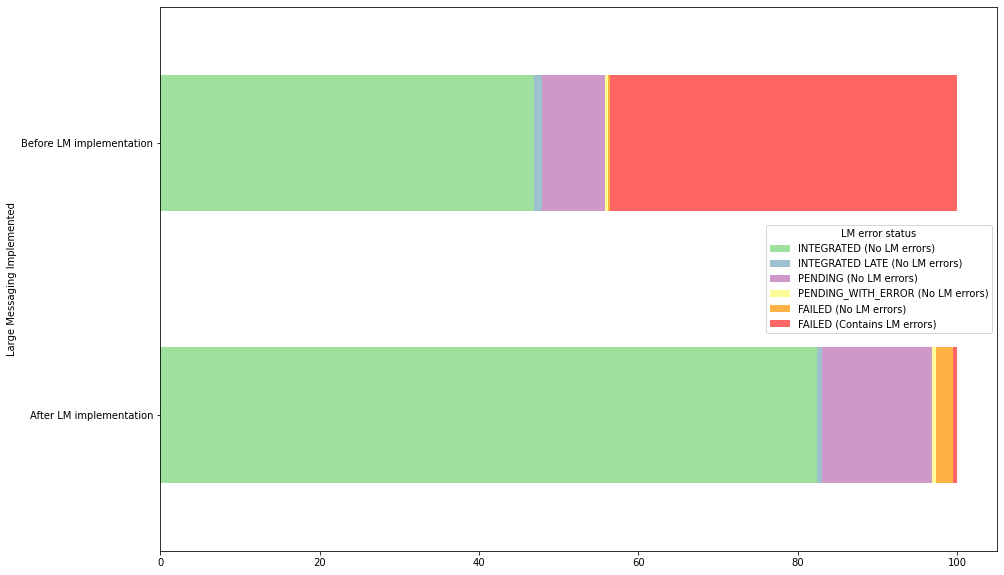

In [56]:
graph_data=lm_error_status_table[['INTEGRATED (No LM errors)','INTEGRATED LATE (No LM errors)','PENDING (No LM errors)','PENDING_WITH_ERROR (No LM errors)','FAILED (No LM errors)','FAILED (Contains LM errors)']]
graph_data_pc=(100*graph_data.div(graph_data.sum(axis=1),axis=0))
graph_data_pc.plot.barh(stacked=True,figsize=(15,10),color=lm_color_table)

In [38]:
area_of_interest_bool=(relevant_transfers['status']=='FAILED') & (relevant_transfers['Large Messaging Available']=='True')
errors_of_interest=relevant_transfers.loc[area_of_interest_bool,'unique_errors'].explode().value_counts()
errors_of_interest.index=[error_names_dict[index] for index in errors_of_interest.index]
pd.DataFrame(errors_of_interest)

,unique_errors
Failed to integrate,4
Req not LM compliant,1
LM general failure,1
Duplicate EHR,1
Failed to generate,1
SDS lookup,1
Extract malformed,1
Wrong patient,1


In [39]:
relevant_transfers['LM status']=relevant_transfers['status']

In [40]:
unexpected_bool=(relevant_transfers['Large Messaging Available']=='True') & (relevant_transfers['Contains LM related error']==True)
#relevant_transfers.loc[unexpected_bool]

,conversation_id,sla_duration,requesting_practice_asid,sending_practice_asid,sender_error_code,final_error_code,intermediate_error_codes,status,date_requested,date_completed,...,ods_code,transfer type,practice,all_errors,unique_errors,Large Messaging Available,Contains LM related error,LM error status,Large Messaging Implemented,LM status
1350291,9504294F-5363-4DFB-89E1-B5FDD7EAF38A,NaN,277476981034,471192226044,30.0,NaN,[],FAILED,2021-03-31 14:17:50.953,NaT,...,H84023,Requesting,FLOOD (ESSEX HOUSE),[30.0],[30.0],True,True,FAILED (Contains LM errors),After LM implementation,FAILED
1452529,51CF99C3-BE3B-493C-BAEA-5820B1A21675,NaN,277476981034,080862447010,14.0,NaN,[],FAILED,2021-03-23 12:17:02.797,NaT,...,H84023,Requesting,FLOOD (ESSEX HOUSE),[14.0],[14.0],True,True,FAILED (Contains LM errors),After LM implementation,FAILED


In [41]:
#asid_lookup.loc[asid_lookup['ASID']=='471192226044']

,ASID,NACS,OrgName,MName,PName,OrgType,PostCode
30968,471192226044,E87063,KINGS ROAD MEDICAL CENTRE,THE PHOENIX PARTNERSHIP,SystmOne,GP Practice,SW10 0UD
